# CounterFactual Experiment

## Import Libraries

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import itertools
import warnings
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.utils import Bunch
from typing import cast
from CounterFactualModel import CounterFactualModel
from ConstraintParser import ConstraintParser
import CounterFactualVisualizer as CounterFactualVisualizer
importlib.reload(CounterFactualVisualizer)
from CounterFactualVisualizer import (plot_pca_with_counterfactual, plot_sample_and_counterfactual_heatmap, 
                                     plot_pca_loadings, plot_constraints, 
                                     plot_sample_and_counterfactual_comparison, plot_pairwise_with_counterfactual_df,
                                     plot_pca_with_counterfactuals, plot_explainer_summary)
from CounterFactualExplainer import CounterFactualExplainer

warnings.filterwarnings("ignore")

## Setup + Constants

In [2]:
CLASS_COLORS_LIST = ['purple', 'green', 'orange']
IRIS: Bunch = cast(Bunch, load_iris())
IRIS_FEATURES = IRIS.data
IRIS_LABELS = IRIS.target

TRAIN_FEATURES, TEST_FEATURES, TRAIN_LABELS, TEST_LABELS = train_test_split(IRIS_FEATURES, IRIS_LABELS, test_size=0.3, random_state=42)

MODEL = RandomForestClassifier(n_estimators=3, random_state=42)
MODEL.fit(TRAIN_FEATURES, TRAIN_LABELS)


ORIGINAL_SAMPLE = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
SAMPLE_DATAFRAME = pd.DataFrame([ORIGINAL_SAMPLE])  # Wrapping sample in a list to create a DataFrame

CONSTRAINT_PARSER = ConstraintParser("constraints/custom_l100_pv0.001_t2_dpg_metrics.txt")
CONSTRAINTS = CONSTRAINT_PARSER.read_constraints_from_file()

cf_dpg = CounterFactualModel(MODEL, CONSTRAINTS, verbose=True)  # Ensure you are using the correct constraints (nested_dict)
TARGET_CLASS = 0
ORIGINAL_SAMPLE_PREDICTED_CLASS = MODEL.predict(SAMPLE_DATAFRAME)

RULES = ['no_change', 'non_increasing', 'non_decreasing']
FEATURES_NAMES = list(ORIGINAL_SAMPLE.keys())
RULES_COMBINATIONS = list(itertools.product(RULES, repeat=len(FEATURES_NAMES)))

NUMBER_OF_COMBINATIONS_TO_TEST = len(RULES_COMBINATIONS)+1
NUMBER_OF_REPLICATIONS_PER_COMBINATION = 10
INITIAL_POPULATION_SIZE = 20
MAX_GENERATIONS = 60


## Constraints Extracted from DPG

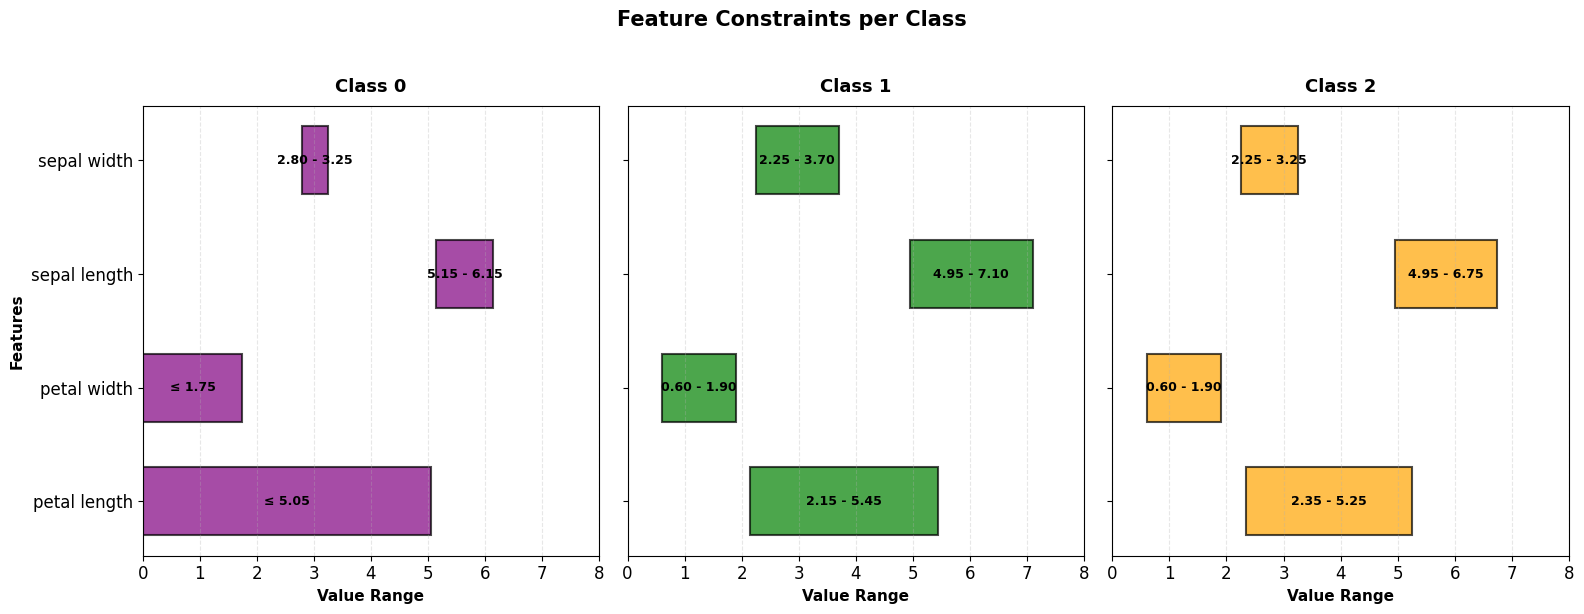

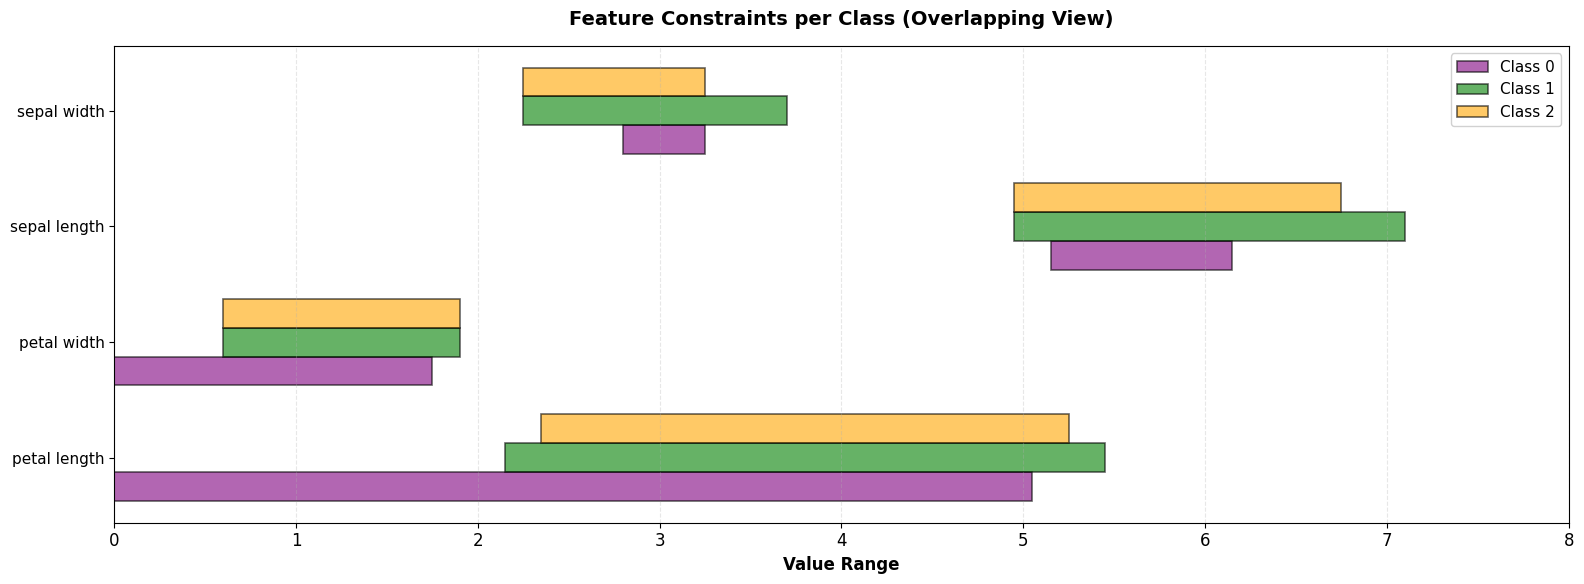

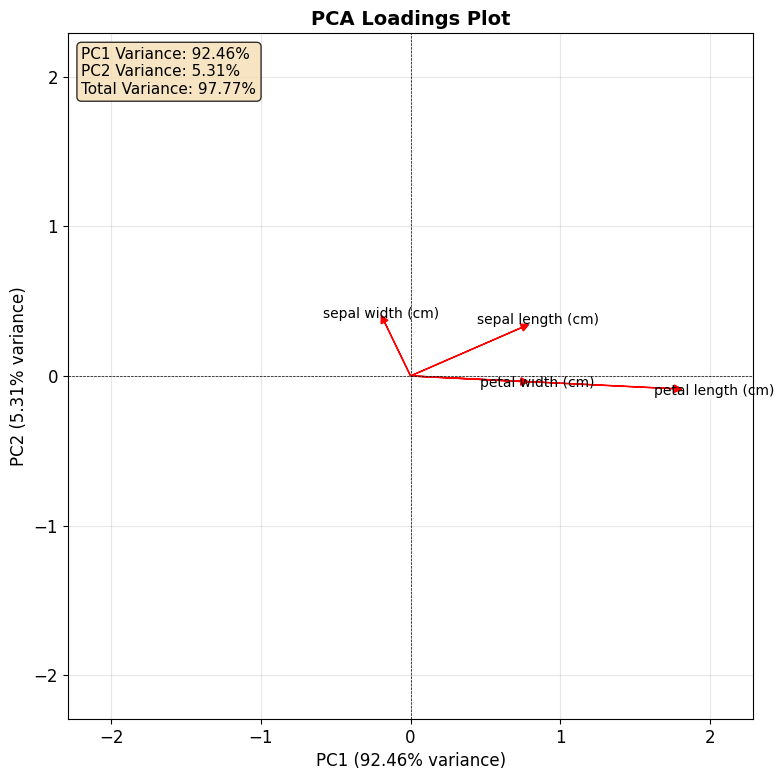

In [3]:

plot_constraints(CONSTRAINTS, overlapping=False, class_colors_list=CLASS_COLORS_LIST)
plot_constraints(CONSTRAINTS, overlapping=True, class_colors_list=CLASS_COLORS_LIST)
plot_pca_loadings(IRIS_FEATURES, IRIS.feature_names)

## Single Counterfactual Example with Custom Rules

Generating counterfactual with rules: {'petal width (cm)': 'non_decreasing', 'petal length (cm)': 'no_change', 'sepal length (cm)': 'non_increasing', 'sepal width (cm)': 'non_decreasing'}

✓ Counterfactual successfully generated!

FEATURE MODIFICATIONS
Feature 'petal width (cm)' changed from 6.1 to 13.89.
Feature 'sepal length (cm)' changed from 4.7 to 0.
Feature 'sepal width (cm)' changed from 1.2 to 1.74.

CONSTRAINTS RESPECT
All constraints were respected.

STOPPING CRITERIA
Stopping criteria not set or not reached.

FINAL RESULTS
Original class: 1, Counterfactual class: 0
Original fitness: inf, Best fitness: inf

VISUALIZATIONS


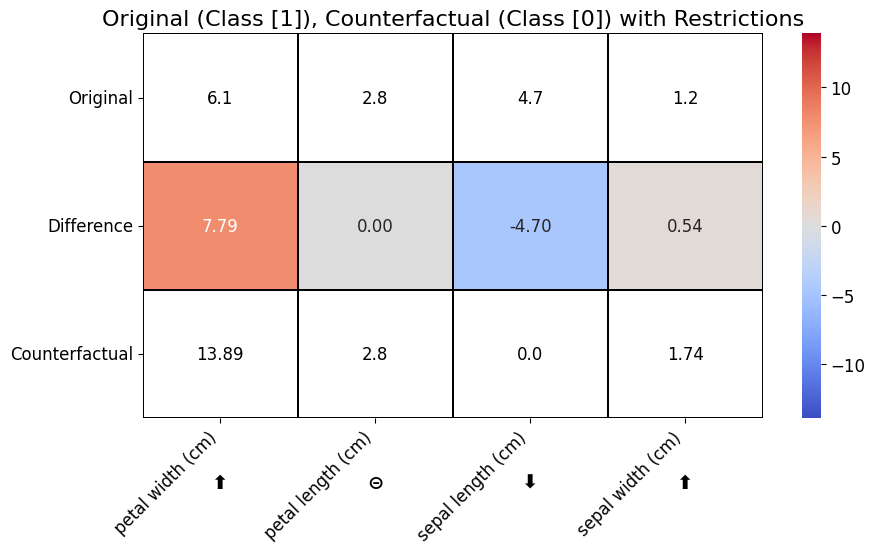

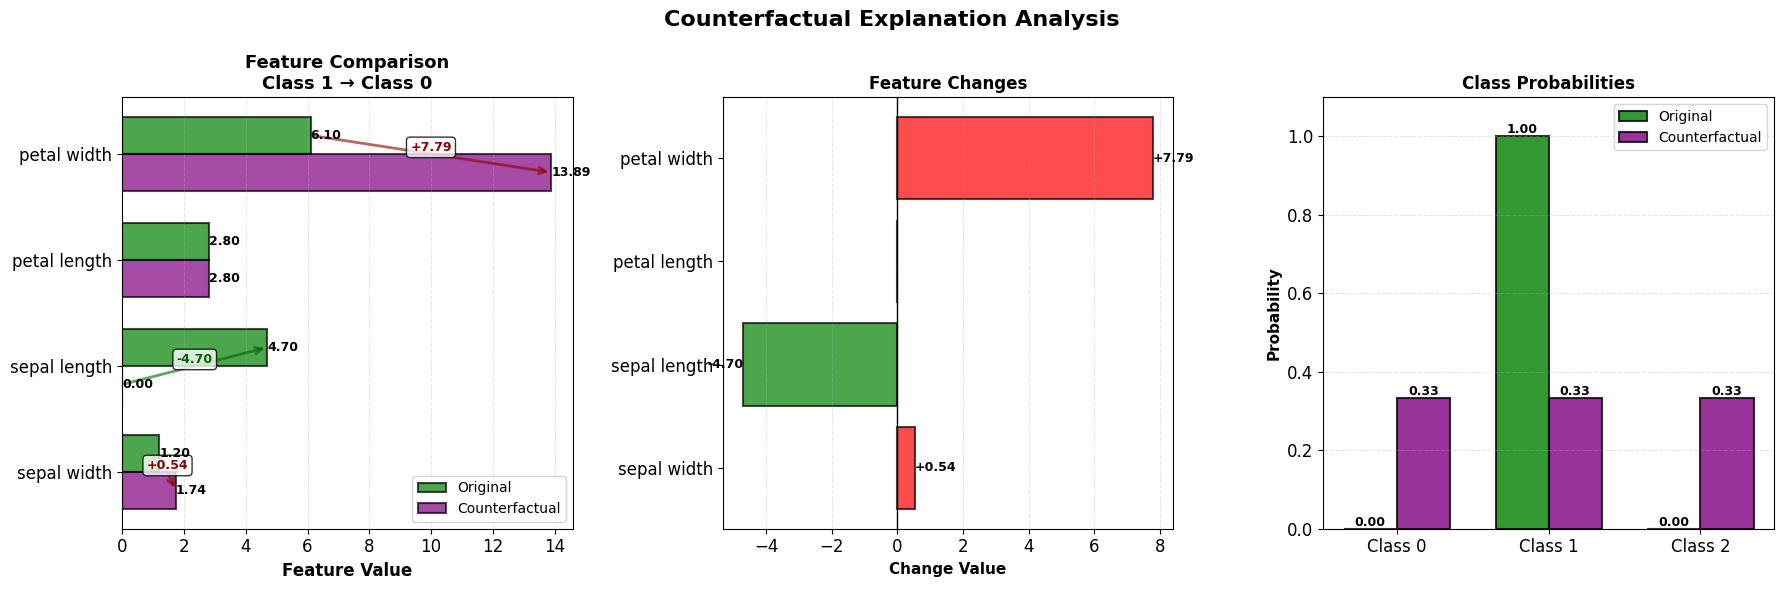

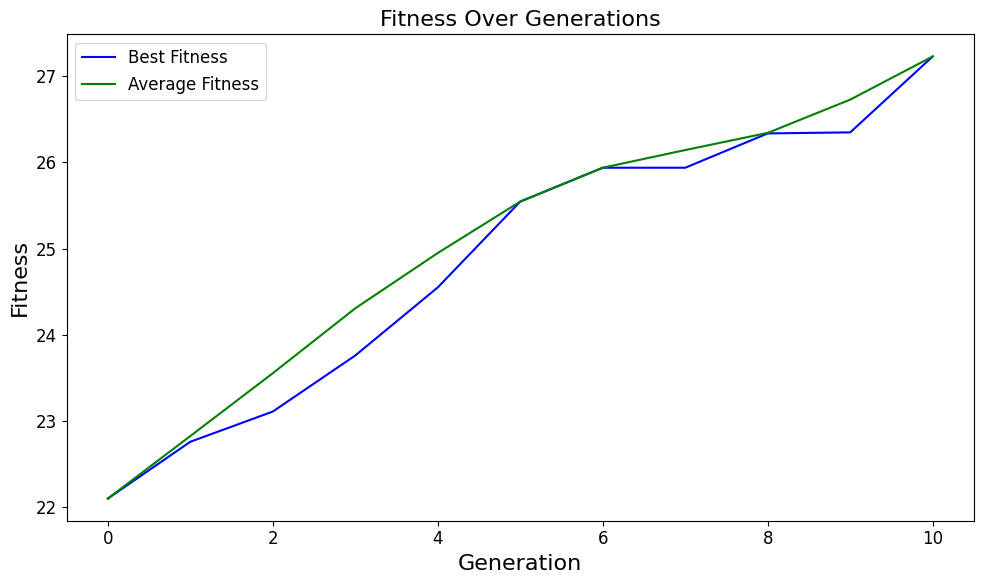

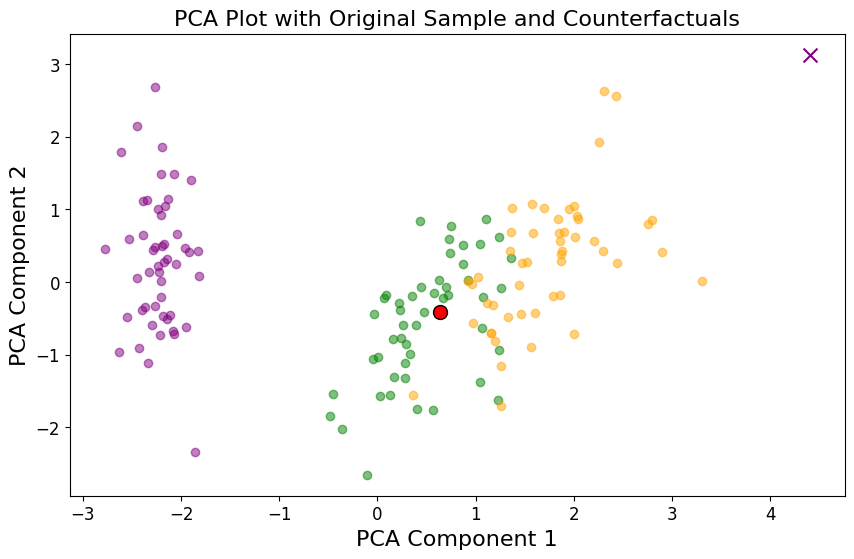

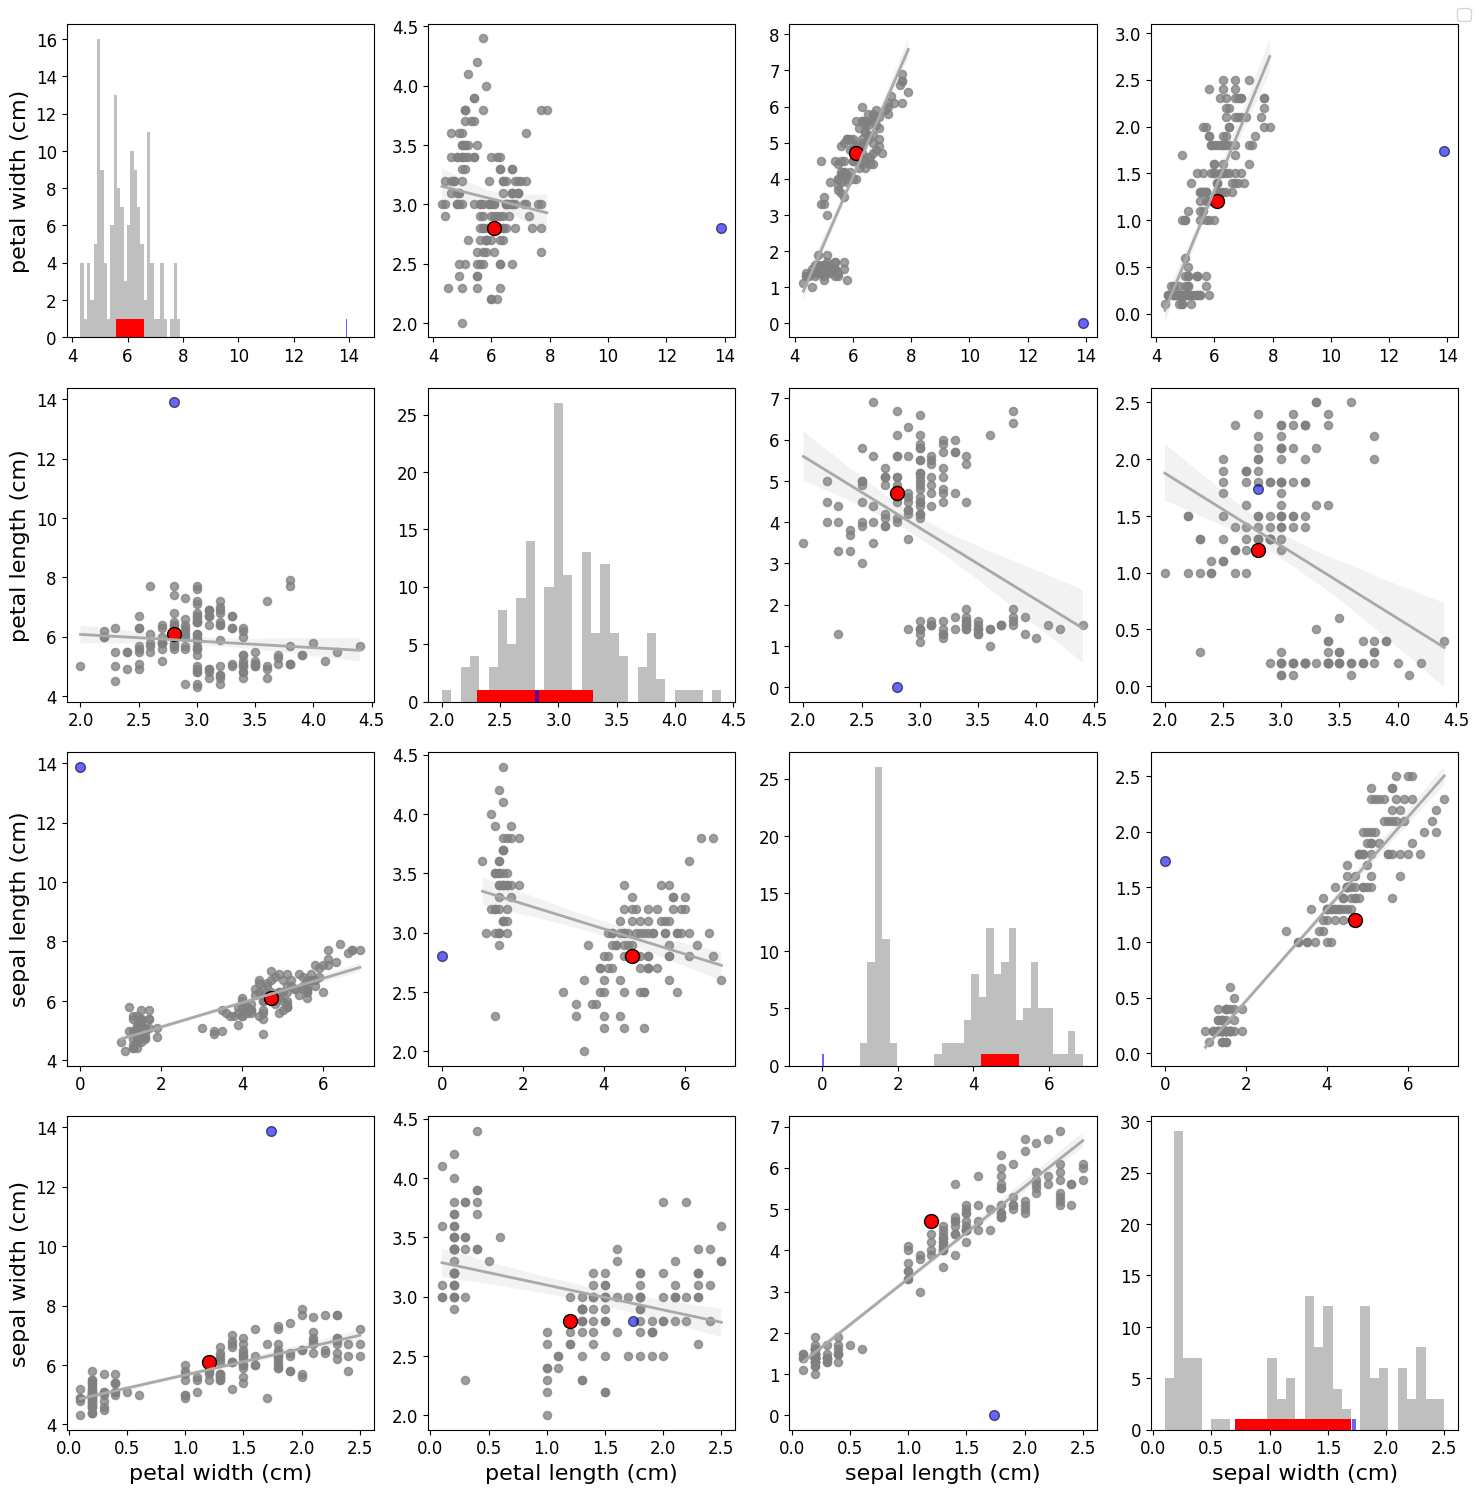

In [11]:
# Define custom rules for this example
custom_rules = {
    'petal width (cm)': 'non_decreasing',
    'petal length (cm)': 'no_change',
    'sepal length (cm)': 'non_increasing',
    'sepal width (cm)': 'non_decreasing'
}

print(f"Generating counterfactual with rules: {custom_rules}\n")

# Create a new CounterFactualModel instance with custom rules
cf_dpg_custom = CounterFactualModel(MODEL, CONSTRAINTS)
cf_dpg_custom.dict_non_actionable = custom_rules

# Generate the counterfactual
custom_counterfactual = cf_dpg_custom.generate_counterfactual(
    ORIGINAL_SAMPLE, 
    TARGET_CLASS, 
    INITIAL_POPULATION_SIZE, 
    MAX_GENERATIONS
)

if custom_counterfactual is not None:
    print(f"✓ Counterfactual successfully generated!")
    
    # Create explainer for metrics
    custom_explainer = CounterFactualExplainer(cf_dpg_custom, ORIGINAL_SAMPLE, custom_counterfactual, TARGET_CLASS)
    
    # Display explanations
    print("\n" + "="*80)
    print("FEATURE MODIFICATIONS")
    print("="*80)
    print(custom_explainer.explain_feature_modifications())
    
    print("\n" + "="*80)
    print("CONSTRAINTS RESPECT")
    print("="*80)
    print(custom_explainer.check_constraints_respect())
    
    print("\n" + "="*80)
    print("STOPPING CRITERIA")
    print("="*80)
    print(custom_explainer.explain_stopping_criteria())
    
    print("\n" + "="*80)
    print("FINAL RESULTS")
    print("="*80)
    print(custom_explainer.summarize_final_results())
    
    # Generate and display visualizations
    print("\n" + "="*80)
    print("VISUALIZATIONS")
    print("="*80)
    
    # Heatmap comparison
    custom_viz_heatmap = plot_sample_and_counterfactual_heatmap(
        ORIGINAL_SAMPLE, 
        ORIGINAL_SAMPLE_PREDICTED_CLASS, 
        custom_counterfactual, 
        MODEL.predict(pd.DataFrame([custom_counterfactual])), 
        custom_rules
    )
    display(custom_viz_heatmap)
    
    # Feature comparison
    custom_viz_comparison = plot_sample_and_counterfactual_comparison(
        MODEL, 
        ORIGINAL_SAMPLE, 
        SAMPLE_DATAFRAME, 
        custom_counterfactual, 
        CLASS_COLORS_LIST
    )
    display(custom_viz_comparison)
    
    # Fitness evolution
    custom_viz_fitness = cf_dpg_custom.plot_fitness()
    display(custom_viz_fitness)
    
    # PCA with single counterfactual
    cf_features_df_single = pd.DataFrame([custom_counterfactual])
    custom_viz_pca = plot_pca_with_counterfactuals(
        MODEL, 
        pd.DataFrame(IRIS_FEATURES), 
        IRIS_LABELS, 
        ORIGINAL_SAMPLE, 
        cf_features_df_single
    )
    display(custom_viz_pca)
    
    # Pairwise plot
    custom_viz_pairwise = plot_pairwise_with_counterfactual_df(
        MODEL, 
        IRIS_FEATURES, 
        IRIS_LABELS, 
        ORIGINAL_SAMPLE, 
        cf_features_df_single
    )
    display(custom_viz_pairwise)
    
else:
    print("✗ Failed to generate counterfactual with the specified rules.")

## Generate Counterfactuals with All Rule Combinations

In [4]:
from ipywidgets import IntProgress, HTML, HBox, Output, Layout
from IPython.display import display, clear_output
import sys

# Create progress widget with fixed positioning
progress_widget = IntProgress(
    value=0,
    min=0,
    max=NUMBER_OF_COMBINATIONS_TO_TEST,
    description='',
    bar_style='info',
    orientation='horizontal',
    layout=Layout(width='500px')
)

progress_text = HTML(value='<b>Progress: 0 / ' + str(NUMBER_OF_COMBINATIONS_TO_TEST) + '</b>')
progress_container = HBox([progress_widget, progress_text], layout=Layout(width='100%', padding='10px'))

# Output area for scrolling logs
logs_output = Output(layout=Layout(height='400px', overflow_y='auto', border='1px solid black', padding='10px'))

# Display the fixed progress widget and scrolling output area
display(progress_container)
display(logs_output)

counterfactuals_df_combinations = []
visualizations = []

for combination_num, combination in enumerate(RULES_COMBINATIONS[:NUMBER_OF_COMBINATIONS_TO_TEST]):
    # Update progress widget
    progress_widget.value = combination_num + 1
    progress_text.value = f'<b>Progress: {combination_num + 1} / {NUMBER_OF_COMBINATIONS_TO_TEST}</b>'
    
    dict_non_actionable = dict(zip(FEATURES_NAMES, combination))
    counterfactuals_df_replications = []
    combination_viz = {
        'label': combination,
        'pairwise': None,
        'pca': None,
        'replication': []
    }
    
    # Track if we should skip this combination
    skip_combination = False
    
    for replication in range(NUMBER_OF_REPLICATIONS_PER_COMBINATION):
        # If 3rd replication failed, skip the rest of this combination
        if skip_combination:
            break
            
        with logs_output:
            print(f"\nCombination {combination_num + 1}/{NUMBER_OF_COMBINATIONS_TO_TEST}: {dict_non_actionable}, Replication: {replication + 1}/{NUMBER_OF_REPLICATIONS_PER_COMBINATION}")
        
        cf_dpg = CounterFactualModel(MODEL, CONSTRAINTS)
        cf_dpg.dict_non_actionable = dict_non_actionable

        counterfactual = cf_dpg.generate_counterfactual(ORIGINAL_SAMPLE, TARGET_CLASS, INITIAL_POPULATION_SIZE, MAX_GENERATIONS)
        if (counterfactual == None):
            # If 3rd replication (index 2) fails, skip the rest of the combination
            if replication == 2:
                with logs_output:
                    print(f"Skipping remaining replications for combination {combination_num + 1} due to failed 3rd replication")
                skip_combination = True
            continue
        
        with logs_output:
            print(f"Counterfactual found for combination: {dict_non_actionable}")

        # Store counterfactual and model in replication_viz object
        replication_viz = {
            'counterfactual': counterfactual,
            'cf_model': cf_dpg,  # Store the model so we can access fitness data later
            'visualizations': [],
            'explanations': []
        }
        combination_viz['replication'].append(replication_viz)

        # Prepare data for DataFrame
        cf_data = counterfactual.copy()
        cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})
        cf_data['Replication'] = replication + 1
        counterfactuals_df_replications.append(cf_data)
    
    # Convert replications to DataFrame (no plotting yet)
    if counterfactuals_df_replications:
        counterfactuals_df_replications = pd.DataFrame(counterfactuals_df_replications)
        
        # Add all replications to the overall combinations list
        counterfactuals_df_combinations.extend(counterfactuals_df_replications.to_dict('records'))
    
    if(combination_viz['replication']):
        visualizations.append(combination_viz)


# Convert all combinations to DataFrame
counterfactuals_df_combinations = pd.DataFrame(counterfactuals_df_combinations)

with logs_output:
    print("\n✓ Counterfactual generation complete!")


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

## Generate Visualizations for Counterfactuals

In [5]:
# Create progress widget for visualization generation
viz_progress_widget = IntProgress(
    value=0,
    min=0,
    max=len(visualizations),
    description='Visualizations:',
    bar_style='info',
    orientation='horizontal',
    layout=Layout(width='500px')
)

viz_progress_text = HTML(value='<b>Progress: 0 / ' + str(len(visualizations)) + '</b>')
viz_progress_container = HBox([viz_progress_widget, viz_progress_text], layout=Layout(width='100%', padding='10px'))

# Output area for scrolling logs
viz_logs_output = Output(layout=Layout(height='400px', overflow_y='auto', border='1px solid black', padding='10px'))

# Display the fixed progress widget and scrolling output area
display(viz_progress_container)
display(viz_logs_output)

# Iterate over all combinations and generate visualizations
for combination_idx, combination_viz in enumerate(visualizations):
    # Update progress widget
    viz_progress_widget.value = combination_idx + 1
    viz_progress_text.value = f'<b>Progress: {combination_idx + 1} / {len(visualizations)}</b>'
    
    dict_non_actionable = dict(zip(FEATURES_NAMES, combination_viz['label']))
    
    with viz_logs_output:
        print(f"\nGenerating visualizations for combination {combination_idx + 1}/{len(visualizations)}: {dict_non_actionable}")
    
    # Generate visualizations for each replication
    for replication_idx, replication_viz in enumerate(combination_viz['replication']):
        counterfactual = replication_viz['counterfactual']
        cf_dpg = replication_viz['cf_model']  # Use the stored model instead of regenerating
        \
        with viz_logs_output:
            print(f"  Replication {replication_idx + 1}/{len(combination_viz['replication'])}")
        
        # Generate replication visualizations
        replication_visualizations = [
            plot_sample_and_counterfactual_heatmap(ORIGINAL_SAMPLE, ORIGINAL_SAMPLE_PREDICTED_CLASS, counterfactual, MODEL.predict(pd.DataFrame([counterfactual])), dict_non_actionable),
            plot_sample_and_counterfactual_comparison(MODEL, ORIGINAL_SAMPLE, SAMPLE_DATAFRAME, counterfactual, CLASS_COLORS_LIST),
            cf_dpg.plot_fitness()  # Use the stored model's fitness data
        ]
        
        # Store visualizations in the replication object
        replication_viz['visualizations'] = replication_visualizations
    
    # Generate combination-level visualizations (PCA and Pairwise)
    # Extract all counterfactuals for this combination
    counterfactuals_list = [rep['counterfactual'] for rep in combination_viz['replication']]
    cf_features_df = pd.DataFrame(counterfactuals_list)
    
    combination_viz['pairwise'] = plot_pairwise_with_counterfactual_df(MODEL, IRIS_FEATURES, IRIS_LABELS, ORIGINAL_SAMPLE, cf_features_df)
    combination_viz['pca'] = plot_pca_with_counterfactuals(MODEL, pd.DataFrame(IRIS_FEATURES), IRIS_LABELS, ORIGINAL_SAMPLE, cf_features_df)

with viz_logs_output:
    print("\n✓ Visualization generation complete!")


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

## Metrics

In [6]:
# Create progress widget for metrics generation
metrics_progress_widget = IntProgress(
    value=0,
    min=0,
    max=len(visualizations),
    description='Metrics:',
    bar_style='info',
    orientation='horizontal',
    layout=Layout(width='500px')
)

metrics_progress_text = HTML(value='<b>Progress: 0 / ' + str(len(visualizations)) + '</b>')
metrics_progress_container = HBox([metrics_progress_widget, metrics_progress_text], layout=Layout(width='100%', padding='10px'))

# Output area for scrolling logs
metrics_logs_output = Output(layout=Layout(height='400px', overflow_y='auto', border='1px solid black', padding='10px'))

# Display the fixed progress widget and scrolling output area
display(metrics_progress_container)
display(metrics_logs_output)

# Iterate over all combinations and generate metrics/explainers
for combination_idx, combination_viz in enumerate(visualizations):
    # Update progress widget
    metrics_progress_widget.value = combination_idx + 1
    metrics_progress_text.value = f'<b>Progress: {combination_idx + 1} / {len(visualizations)}</b>'
    
    dict_non_actionable = dict(zip(FEATURES_NAMES, combination_viz['label']))
    
    with metrics_logs_output:
        print(f"\nGenerating metrics for combination {combination_idx + 1}/{len(visualizations)}: {dict_non_actionable}")
    
    # Generate metrics for each replication
    for replication_idx, replication_viz in enumerate(combination_viz['replication']):
        counterfactual = replication_viz['counterfactual']
        cf_dpg = replication_viz['cf_model']
        
        with metrics_logs_output:
            print(f"  Replication {replication_idx + 1}/{len(combination_viz['replication'])}")
        
        # Generate individual explainer metrics
        EXPLAINER = CounterFactualExplainer(cf_dpg, ORIGINAL_SAMPLE, counterfactual, TARGET_CLASS)
        
        # Collect individual metrics as text strings
        feature_modifications = EXPLAINER.explain_feature_modifications()
        constraints_respect = EXPLAINER.check_constraints_respect()
        stopping_criteria = EXPLAINER.explain_stopping_criteria()
        final_results = EXPLAINER.summarize_final_results()
        
        # Append individual metrics to explanations list as text
        replication_viz['explanations'].append(f"Feature Modifications:\n{feature_modifications}")
        replication_viz['explanations'].append(f"Constraints Respect:\n{constraints_respect}")
        replication_viz['explanations'].append(f"Stopping Criteria:\n{stopping_criteria}")
        replication_viz['explanations'].append(f"Final Results:\n{final_results}")

with metrics_logs_output:
    print("\n✓ Metrics generation complete!")

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [7]:
# Display visualizations with dropdown picker for combination selection
from ipywidgets import Dropdown, Output, VBox, HTML, Layout, IntSlider, HBox

# Define color mapping for rules
RULE_COLORS = {
    'no_change': '#FF6B6B',  # Red
    'non_increasing': '#4ECDC4',  # Teal
    'non_decreasing': '#123456'  # blue
}

# Create combination slider
num_combinations = len(visualizations)
combination_slider = IntSlider(
    value=0,
    min=0,
    max=max(0, num_combinations - 1),
    step=1,
    description='Combination:',
    layout=Layout(width='500px')
)

# Create combined label to show features and current rules
def create_combined_label(combination_idx):
    """Create a label combining features and their corresponding rules with color coding"""
    if not visualizations:
        return "<b>No visualizations available</b>"
    
    rules_tuple = visualizations[combination_idx]['label']
    label_parts = []
    for feat, rule in zip(FEATURES_NAMES, rules_tuple):
        color = RULE_COLORS.get(rule, '#000000')
        label_parts.append(f"<b>{feat}=</b><span style='color: {color}; font-weight: bold;'>{rule}</span>")
    
    return "<br>".join(label_parts)

combined_label = HTML(value=create_combined_label(0))

# Create replication slider
replication_slider = IntSlider(
    value=0,
    min=0,
    max=0,
    step=1,
    description='Replication:',
    layout=Layout(width='500px')
)

# Create output areas
combination_output_area = Output()  # For PCA and Pairwise plots
replication_output_area = Output()  # For replication visualizations

def display_combination_plots(combination_idx):
    """Display PCA and Pairwise plots for selected combination"""
    combination_output_area.clear_output(wait=True)
    with combination_output_area:
        combination_viz = visualizations[combination_idx]

        if combination_viz['pca'] is not None:
            display(combination_viz['pca'])

        if combination_viz['pairwise'] is not None:
            display(combination_viz['pairwise'])

def display_replication(combination_idx, replication_idx):
    """Display visualizations for selected replication"""
    replication_output_area.clear_output(wait=True)
    with replication_output_area:
        combination_viz = visualizations[combination_idx]
        replication_viz = combination_viz['replication'][replication_idx]
        
        print(f"Replication {replication_idx + 1}:")

        for viz_idx, viz in enumerate(replication_viz['explanations']):
            display(viz)

        # Use nested visualizations list
        for viz_idx, viz in enumerate(replication_viz['visualizations']):
            display(viz)

# Setup event handler for combination change
def on_combination_change(change):
    combination_idx = change['new']
    
    # Update combined label with features and rules
    combined_label.value = create_combined_label(combination_idx)
    
    # Update replication slider range
    num_replications = len(visualizations[combination_idx]['replication'])
    replication_slider.max = num_replications - 1
    replication_slider.value = 0
    
    # Update combination slider max label
    combination_slider_label.value = f"/ {combination_slider.max}"
    
    # Update replication slider max label
    replication_slider_label.value = f"/ {replication_slider.max}"
    
    # Display combination plots
    display_combination_plots(combination_idx)
    
    # Display first replication
    display_replication(combination_idx, 0)

# Setup event handler for replication change
def on_replication_change(change):
    combination_idx = combination_slider.value
    replication_idx = change['new']
    display_replication(combination_idx, replication_idx)

combination_slider.observe(on_combination_change, names='value')
replication_slider.observe(on_replication_change, names='value')

# Create slider labels for max values
combination_slider_label = HTML(value=f"/ {combination_slider.max}", layout=Layout(width='auto', margin='5px 0 0 10px'))
replication_slider_label = HTML(value=f"/ {replication_slider.max}", layout=Layout(width='auto', margin='5px 0 0 10px'))

# Wrap sliders with labels
combination_slider_with_label = HBox([combination_slider, combination_slider_label])
replication_slider_with_label = HBox([replication_slider, replication_slider_label])

# Display initial combination
on_combination_change({'new': 0})

# Show combined label, sliders and output areas
display(VBox([combined_label, combination_slider_with_label, combination_output_area, replication_slider_with_label, replication_output_area]))
